<a href="https://colab.research.google.com/github/citurriagab/CNN_M6_Trab2/blob/main/2022.09.14_KMNIST_CNN_CITURRIAGA_RLEFIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trabajo N° 2

#### Deep Learning 

**Análisis Supervisado**

**Clasificación**

*Carla Iturriaga Barrios*

*Rodrigo Lefin Carrasco*

Septiembre, 2022

### Presentación del proyecto.

*Una empresa de consultoria que presta servicios de traducción, utilizando herramientas de Deep Learning, tiene un nuevo cliente que requiere **identificar letras del japonés clásico pero desde imágenes**.*

**Fuente de datos**: *Dataset correspondiente a imagenes de datos reimpresos del japonés clásico "Kuzushiji" obtenido directamente de la librería pytorch*

### Objetivo del proyecto.

1. *Construir un modelo que sea capaz de clasificar y categorizar en letras del japonés clásico un conjunto de imágenes de la letra desde textos reimpresos.*

**Se establece como valor minimo deseable que las predicciones, del modelo construido, sean correctas en al menos un 80%.**

### Preparación del entorno

In [1]:
from torchvision import datasets
from torchvision import transforms 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import datetime
import torchvision
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

### 1: Datos

*Los siguientes datos corresponden a una base de 70.000 imagenes de 28x28 con la reimpresión de textos japoneses. La categorización de ellas se divide en 10 clases correspondientes a letras del japonés clásico, tales como: **'o', 'ki', 'su', 'tsu', etc**.*

In [2]:
path = './data/'

# configuración de dataset de entrenamiento y de prueba
df = datasets.KMNIST(path, train=True, download=True)
df_test = datasets.KMNIST(path, train=False, download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [3]:
# Largo del dataset
print('Registros de entrenamiento:', len(df))
print('Registros de prueba:', len(df_test))

Registros de entrenamiento: 60000
Registros de prueba: 10000


In [4]:
# Especificación de las etiquetas/label
df.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

#### Previsualización de imagenes del dataset

*En adelante, se muestran algunos ejemplares de los registros del dataset KMNIST, correspondiente a la letra en compañía con su etiqueta o clase*

la siguiente imagen corresponde al label: 5 correspondiente a: ha


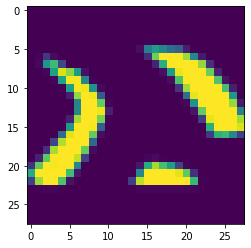

In [5]:
#Previsualización de una imagen dentro del dataset
img, label = df[10]
plt.imshow(img)
print('la siguiente imagen corresponde al label:', label, 'correspondiente a:', df.classes[label])
plt.show()

la siguiente imagen corresponde al label: 2 correspondiente a: su


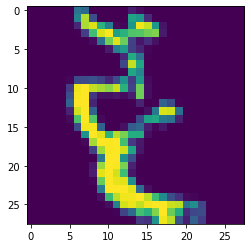

In [6]:
#Previsualización de una imagen dentro del dataset
img2, label2 = df[90]
plt.imshow(img2)
print('la siguiente imagen corresponde al label:', label2, 'correspondiente a:', df.classes[label2])
plt.show()

la siguiente imagen corresponde al label: 3 correspondiente a: tsu


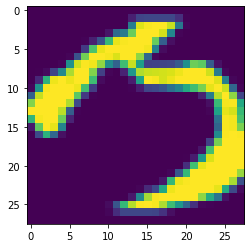

In [7]:
#Previsualización de una imagen dentro del dataset
img3, label3 = df[25000]
plt.imshow(img3)
print('la siguiente imagen corresponde al label:', label3, 'correspondiente a:', df.classes[label3])
plt.show()

#### Transformación y Normalización de imagenes a tensor de PyTorch

*Para seguir con el análisis y modelamiento, es requerido transformar los registros del dataset desde imágenes a tensores y, posteriormente, normalizar sus medidas de promedio y desviación estándar*

In [8]:
# Transformar data a tensor de pytorch y normalizar
df = datasets.KMNIST(
    path, train=True, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        
    ])
)

df_test = datasets.KMNIST(
    path, train=False, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))

    ])
)

#### Información del dataset

*En adelante, se muestra la descripción del set de datos de entrenamiento y de testeo: Ambos con la definición de dimensión, ubicación y las transformaciones que se han aplicado*

In [9]:
print('Entrenamiento: ', df)

Entrenamiento:  Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )


In [10]:
print('Prueba: ', df_test)

Prueba:  Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )


#### Visualización de los registros transformados en Tensores

*En adelante, se genera una demostración gráfica del nuevo registro tensor*

La siguiente imagen corresponde al label: 5 correspondiente a: ha


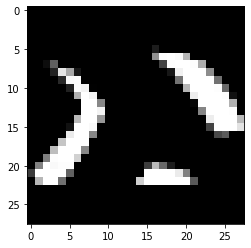

In [11]:
# Graficar la imagen transformada
img_t, label = df[10]
plt.imshow(torchvision.utils.make_grid(img_t, nrow=5).permute(1, 2, 0))
print('La siguiente imagen corresponde al label:', label, 'correspondiente a:', df.classes[label])
plt.show()

### 2. Modelo

*Dado el tipo de registros (imágenes) e información con la que se está trabajando en el presente proyecto, se decide configurar y entrenar el modelo **CNN** (Convolutional Neural Network)*

*Para ello, se desarrolla, a continuación, la red neuronal con **2 hiden layers**, donde el registro de entrada al primer layer corresponde a un **input de 3 dimensiones** y la última **salida correspondería a 10 clases**.*

In [12]:
# Model 
class CNN(nn.Module):
    """Cada arquitectura es una forma funcional de la red."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # convolutional layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolutional layer
        self.fc1 = nn.Linear(8 * 7 * 7, 32)                     # Fully connected
        self.fc2 = nn.Linear(32, 10)                             # Fully connected

    def forward(self, x): # input img
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)        # max pooling torch.Size([64, 3, 28, 28])
        #print(out.shape)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)      # max pooling
        #print(out.shape)
        out = out.view(-1, 8 * 7 * 7)                           # tranform the out
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out  # dim: number of class

*En la siguiente **función de entrenamiento**, queda definido genericamente el proceso en bucle al que deben someterse las imágenes/tensores para entrenar el modelo, donde se tiene como input la cantidad de iteraciones (epochs), el modelo (CNN), optimizador, la función de error y la definición de los batches*

In [13]:
# Training function 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 
        for imgs, labels in train_loader:  # batch 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()               # backpro
            optimizer.step()              # update w
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 20 == 0:
            print('Epoch {}, Training loss {}'.format(epoch,
            loss_train / len(train_loader)))
            loss_list.append(loss_train / len(train_loader))
    return loss_list
            

#### Entrenando el modelo...

*Se ha decidido establecer dos escenarios para entrenar y evaluar el modelo CNN, como anteriormente se definió, donde:*

1. **Primer Escenario**

  * *El **Optimizador** definido será **SGD**, como punto inicial.*

  * *En cuanto a la **Función de pérdida**, se utilizará **Cross Entropy** ya que este proyecto es de clasificación*

2. **Segundo Escenario**

  * *El **Optimizador** definido será **Adam**, dado que al ser una versión más actual y al estar construido en base a SGD, se espera un rendimiento superior en sus resultados*

  * *Mientras que, la **Función de pérdida** seguirá siendo **Cross Entropy** ya que este proyecto es de clasificación*

**Hiperparámetros (W)**

*En términos de los hiperparametros del modelo CNN:*

- **Batches**: Se optará por **64**, en ambos escenarios, para la división de la base de datos.

- **Learning Rate (lr)**: Este se definirá como **0.1 para el Primer escenario** y **0.01 en el caso del Segundo escenario**, con la intención de buscar el valor óptimo del error.

- **Epochs**: La cantidad de iteraciones serán **200**, dado que se requiere un número alto, dado el volumen de los datos, para la búsqueda del valor óptimo y disminuir lo más posible el error.

In [14]:
torch.randn(64,8,8,8).shape

torch.Size([64, 8, 8, 8])

In [15]:
# Dataloader
train_loader = torch.utils.data.DataLoader(df, batch_size=64, shuffle=True)

In [16]:
model=CNN()

In [17]:
count = 0
for imgs, label in train_loader:
  if count==0:
    outputs = model(imgs)
    #print(imgs.shape)
    print(outputs)
    count +=1

tensor([[-1.3193e-01,  1.6839e-01,  2.0357e-01,  1.0512e-01, -1.1077e-01,
         -1.2190e-01, -1.2630e-01,  1.3499e-02,  2.4893e-01, -1.0749e-01],
        [-1.7658e-01,  1.0743e-01,  1.7414e-01,  2.8687e-02, -2.1235e-01,
         -1.3461e-01, -2.4790e-01, -1.1312e-01,  2.0225e-01, -9.2920e-02],
        [-2.5604e-01,  7.2910e-02,  1.6920e-01, -4.0539e-02, -2.6084e-01,
         -1.7835e-01, -2.7757e-01, -8.6886e-02,  2.4419e-01, -8.4314e-02],
        [-1.2392e-01,  1.5715e-01,  1.5822e-01,  2.5602e-03, -7.9887e-02,
         -4.0676e-02, -2.1236e-01, -1.4659e-01,  1.6345e-01, -1.0528e-01],
        [-1.8117e-01,  2.8164e-02,  1.8620e-01,  3.2790e-03, -1.6261e-01,
         -7.0381e-02, -1.9787e-01, -1.3725e-02,  1.5156e-01, -1.3499e-01],
        [-2.1153e-01,  9.3497e-02,  2.9676e-01,  7.1985e-02, -1.5213e-01,
         -7.7618e-02, -1.8758e-01, -9.0568e-02,  2.1455e-01, -1.1054e-01],
        [-1.7542e-01,  1.7223e-01,  1.1095e-01,  1.0938e-01, -1.4471e-01,
         -1.3448e-01, -1.9321e-0

In [18]:
len(train_loader)

938

#### **Procesando CNN con la muestra KMNIST...**

##### **Primer Escenario**

*El primer escenario a analizar en el modelo CNN será considerando el dataset dividido en 64 Batches, Learning Rate de 0.1, Cross Entropy como función de pérdida y SGD como optimizador.*

*Son 200 las iteraciones que se obtendrán al finalizar el proceso, dentro del cual, se obtendrán los valores resultantes de "Loss" en búsqueda del valor óptimo y disminución de errores.* 

*Con esto último, se generará un gráfico demostrativo **Loss vs Epochs**.*

In [19]:
# Run, traning
model1 = CNN()                                            # call our cnn class
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1) # Stochastic gradient descent
loss_fn1 = nn.CrossEntropyLoss()                          # Loss function

Loss1 = training_loop(
    n_epochs = 200,
    optimizer = optimizer1,
    model = model1,
    loss_fn = loss_fn1,
    train_loader = train_loader,
)

Epoch 1, Training loss 0.5980687998314657
Epoch 20, Training loss 0.04407776763507806
Epoch 40, Training loss 0.015004293518518208
Epoch 60, Training loss 0.006392629423761057
Epoch 80, Training loss 0.003817570710061133
Epoch 100, Training loss 0.002676410437958724
Epoch 120, Training loss 0.0020432676731970962
Epoch 140, Training loss 0.0016449714211645527
Epoch 160, Training loss 0.0013770734462060475
Epoch 180, Training loss 0.0011583240824298677
Epoch 200, Training loss 0.0010065964190041157


*En cuanto al reciente resultado del procesamiento del modelo en el escenario 1 (SGD - lr: 0.1), se ha demorado 1 hora con 7 minutos en terminar las 200 iteraciones, disminuyendo su valor de Loss desde 0.57 a 0.0009, de lo cual se puede mencionar que:* **el valor óptimo dentro de las 200 iteraciones realizaadas, se encuentra en la última iteración, especificamente**

##### Visualización de la función de pérdida (Loss F.)

**Primer Escenario**

*El siguiente gráfico presenta la curvatura que va tomando el error al avanzar las 200 iteraciones del modelo, de ello se puede mencionar que:*

  * *En primera instancia, los errores toman valores altos que van disminuyendo al iterar cada vez más, visualizándose como una curva de tipo exponencial, donde se puede observar su valor óptimo en la última iteración (200 -> 0.0009).*

Text(0, 0.5, 'Loss')

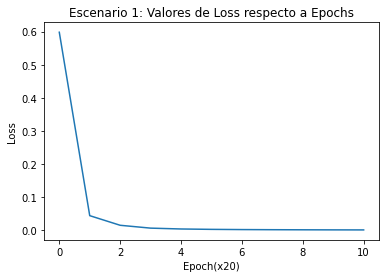

In [20]:
# plot loss
plt.plot(Loss1)
plt.title('Escenario 1: Valores de Loss respecto a Epochs')
plt.xlabel('Epoch(x20)')
plt.ylabel('Loss')

##### **Métricas**

**Primer Escenario**

*Dentro de las métricas a calcular para definir qué tan bueno es el modelo desarrolado, se tienen las siguientes:*

  - Accuracy

  - Precision

  - Recall

  - F1 Score

In [21]:
# Testing metric
train_loader = torch.utils.data.DataLoader(df, batch_size=64,
                                            shuffle=False)
test_loader = torch.utils.data.DataLoader(df_test, batch_size=64,
                                            shuffle=False)
#model1
def validate(model1, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model1(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                # metrics: Acc, F1, AUC, Precision, Recall, 
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))        
        print("Precision {}: {:.2f}".format(name , precision_score(labels.numpy(), predicted.numpy(), average='micro')))
        print("Recall {}: {:.2f}".format(name , recall_score(labels.numpy(), predicted.numpy(), average='micro')))
        print("F1 Score {}: {:.2f}".format(name , f1_score(labels.numpy(), predicted.numpy(), average='macro')))
        #print("AUC {}: {:.2f}".format(name , roc_auc_score(labels.numpy(), predicted.numpy(), average='micro'))) # ---> Se tiene que armar un predict_tab a traves de una fn

validate(model1, train_loader, test_loader)

Accuracy train: 1.00
Precision train: 1.00
Recall train: 1.00
F1 Score train: 1.00
Accuracy val: 0.91
Precision val: 0.88
Recall val: 0.88
F1 Score val: 0.89


*De acuerdo a las métricas anteriores, se define que el **Modelo CNN para el Primer Escenario** construido para clasificar en letras del japonés clásico imágenes de texto reimpreso es un modelo bueno para predecir, fundamentado en los valores de:*

* **"Accuracy"**, *alcanzando un XX% con la data de entrenamiento y un XX% con la de testeo.

  *Lo cual, indica que el Modelo del Primer Escenario es capaz de acertar en el XX% de las letras japonesas de entrenamiento y XX% de testeo.*

* **"Precision"**, *obteniendo un XX% en entrenamiento y XX% en testeo.*

  *Presentando altos índices de calidad en el modelo.*

* **"Recall"**, *resultando en el XX% dentro de las imágenes de entrenamiento y XX% de testeo.*

  *Es decir, el modelo para el escenario 1, es capaz de aportar una alta cantidad de valores positivos correctamente clasificados.*

* **"F1 Score"**, *presentando un XX% en cuanto a las imágenes de entrenamiento y un XX% en las de testeo.*

  *Donde, se puede asumir que el escenario 1 del modelo, el índice de rendimiento entre precisión y exhaustividad es alto.*


*De lo anterior, es relevante mencionar que en términos comparativos de valores de entrenamiento y de testeo, los resultados de las métricas presentadas son bastantes parecidas y bordean el 80%, valor target definido como "mínimo esperable". Por lo tanto, son valores bastantes altos, en general. Determinando, nuevamente que **el modelo del primer escenario es un buen modelo predictor/clasificador**.*

##### **Segundo Escenario**

*En el caso del escenario número 2 a analizar para el modelo CN, será contemplando el dataset dividido en 64 Batches, también, un Learning Rate de 0.01, Cross Entropy como función de pérdida y ADAM como optimizador, dado que se busca mejorar los resultados anteriores con una nueva versión.*

*Son 200 las iteraciones que se obtendrán al finalizar el proceso, dentro del cual, se obtendrán los valores que entrega "Loss" en búsqueda del valor óptimo y disminución de errores.* 

*Con esto último, se generará un gráfico demostrativo **Loss vs Epochs**.*

In [22]:
# Run, traning
model2 = CNN()                                              # call our cnn class
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.01)  # Adaptive Moment Estimation(Adam)
loss_fn2 = nn.CrossEntropyLoss()                            # Loss function

Loss2 = training_loop(
    n_epochs = 200,
    optimizer = optimizer2,
    model = model2,
    loss_fn = loss_fn2,
    train_loader = train_loader,
)

Epoch 1, Training loss 2.3135596236694598
Epoch 20, Training loss 2.3135596236694598
Epoch 40, Training loss 2.3135596236694598
Epoch 60, Training loss 2.3135596236694598
Epoch 80, Training loss 2.3135596236694598
Epoch 100, Training loss 2.3135596236694598
Epoch 120, Training loss 2.3135596236694598
Epoch 140, Training loss 2.3135596236694598
Epoch 160, Training loss 2.3135596236694598
Epoch 180, Training loss 2.3135596236694598
Epoch 200, Training loss 2.3135596236694598


*El resultado del procesamiento del modelo en su segundo escenario (ADAM - lr: 0.01), se ha demorado 1 hora con 50 minutos en terminar las 200 iteraciones, disminuyendo su valor de Loss desde 0.51 a 0.22, de lo cual se puede mencionar que:* **el valor óptimo dentro de las 200 iteraciones realizadas, se encuentra en la ante penúltima iteración mostrada, epoch 160, especificamente**

##### Visualización de la función de pérdida (Loss F.)

**Segundo Escenario**

*El siguiente gráfico presenta la curvatura que va tomando el error al avanzar las 200 iteraciones del modelo, de ello se puede mencionar que:*

  * *En primera instancia, los errores toman valores altos que van disminuyendo al avanzar las iteraciones, sin embargo, también se presentan variaciones incrementales del valor de Loss, representando una curva no homogénea ni líneal, donde se encuentra su valor óptimo en la ante penúltima iteración (160 -> 0.19).*

Text(0, 0.5, 'Loss')

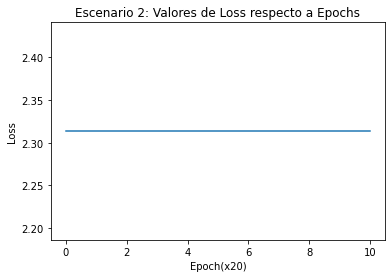

In [23]:
# plot loss
plt.plot(Loss2)
plt.title('Escenario 2: Valores de Loss respecto a Epochs')
plt.xlabel('Epoch(x20)')
plt.ylabel('Loss')

##### **Métricas**

**Segundo Escenario**

*Dentro de las métricas a calcular para definir qué tan bueno es el modelo desarrolado, se tienen las siguientes:*

  - Accuracy

  - Precision

  - Recall

  - F1 Score

In [24]:
# Testing metric
train_loader = torch.utils.data.DataLoader(df, batch_size=64,
                                            shuffle=False)
test_loader = torch.utils.data.DataLoader(df_test, batch_size=64,
                                            shuffle=False)
#model2
def validate(model2, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model2(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                # metrics: Acc, F1, AUC, Precision, Recall, 
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))        
        print("Precision {}: {:.2f}".format(name , precision_score(labels.numpy(), predicted.numpy(), average='micro')))
        print("Recall {}: {:.2f}".format(name , recall_score(labels.numpy(), predicted.numpy(), average='micro')))
        print("F1 Score {}: {:.2f}".format(name , f1_score(labels.numpy(), predicted.numpy(), average='macro')))
        #print("AUC {}: {:.2f}".format(name , roc_auc_score(labels.numpy(), predicted.numpy(), average='micro'))) # ---> Se tiene que armar un predict_tab a traves de una fn

validate(model2, train_loader, test_loader)

Accuracy train: 0.08
Precision train: 0.06
Recall train: 0.06
F1 Score train: 0.03
Accuracy val: 0.09
Precision val: 0.06
Recall val: 0.06
F1 Score val: 0.02


*De acuerdo a las métricas anteriores, se define que el **Modelo CNN para el Segundo Escenario** construido para clasificar en letras del japonés clásico imágenes de texto reimpreso es un modelo bueno para predecir, fundamentado en los valores de:*

* **"Accuracy"**, *alcanzando un 93% con la data de entrenamiento y un 84% con la de testeo.

  *Lo cual, indica que el Modelo del Primer Escenario es capaz de acertar en el 93% de las letras japonesas de entrenamiento y 84% de testeo.*

* **"Precision"**, *obteniendo un 91% en entrenamiento y 88% en testeo.*

  *Presentando altos índices de calidad en el modelo.*

* **"Recall"**, *resultando en el 91% dentro de las imágenes de entrenamiento y 88% de testeo.*

  *Es decir, el modelo para el escenario 2, es capaz de aportar una alta cantidad de valores positivos correctamente clasificados.*

* **"F1 Score"**, *presentando un 87% en cuanto a las imágenes de entrenamiento y un 78% en las de testeo.*

  *Donde, se puede asumir que el escenario 2 del modelo, el índice de rendimiento entre precisión y exhaustividad es alto.*


*De lo anterior, es relevante mencionar que en términos comparativos de valores de entrenamiento y de testeo, los resultados de las métricas presentadas son bastantes parecidas y casi todas superan el 80%, valor target definido como "mínimo esperable". Por lo tanto, son valores bastantes altos, en general. Determinando, nuevamente que **el modelo del 2do escenario es un buen modelo predictor/clasificador**.*

### Conclusión.

*En términos comparativos, se puede concluir que ambos escenarios construyen un modelo que sirve para predecir y es bueno clasificando los registros del dataset KMNIST, capaces de categorizar en letras japonesas las imágenes presentadas de forma correcta aproximadamente en el 80% de ellas para ambos casos (como al principio del documento se definió).*

*En principio, se puede mencionar que al iniciar el procesamiento de los modelos, el segundo (ADAM, lr=0.01) presenta menores valores de Loss desde el primer epoch, sin embargo finaliza con mayor Loss que el primer escenario, diferenciandose en 0.22 puntos.*

*Ya posteriormente, al calcular las métricas definidas de clasificación, el segundo escenario (ADAM, lr=0.01) obtiene mejores resultados en cuanto a las imágenes de entrenamiento como las de testeo. Obteniendo mejores índices de precisión en la predicción, en la calidad y cantidad de sus resultados correctos y en la exactitud de los mismos.*

*Por ende, **se define y elige como mejor modelo el del escenario n° 2 (ADAM, lr=0.01)**, dado que predice y categoriza de mejor manera las imágenes de texto reimpreso presentadas en el dataset KMNIST, siendo capaz de clasificar en letras del japonés clásico Kuzushiji con mayor **precisión**.*
